# Main Pipeline for Single-cell IC analysis (IO / RH / CH / SCH)
---
## How to Run
1) Install packages (one-liner)
   ```bash
   pip install numpy pandas matplotlib seaborn scikit-learn
   ```
   *(Your project also uses `plots_with_stats`, `get_index`, `batch_process`, `io_secondary_properties` — keep them alongside this script.)*
2) Put your data under **main_path** (see below). The **data contract** is enforced upstream by your code:
   - **Folder index** is derived from folder names; `_` splits conditions.
   - **One file per cell**; a file **can have more than one block**.
   - **Channels**: data (Vm) = **0**, stim = **1**.
   - **Units**: Vm **mV**, I **pA**, time **ms**, Rin **MΩ**, C **pF**, G **nS**.
   - **Tags**: `io_start/io_stop`, `rh_start/rh_stop`, `ch_start/ch_stop`, `sch_start/sch_stop`.
   - **Spike prominence** = **25** for all cells.
   - **Stim correction** = **1000** for all cells.
3) **First run:** execute cells **one-by-one** (this script creates output folders and a first-run flag). After that, you can **Run All**.
4) **Outputs** (created under `FIG_ROOT` and `EXPORT_ROOT`):
   - Every plot is exported as **SVG + PNG** and the **exact plotted data as CSV**.
   - A small meta JSON is also written per figure with parameters.

---

### Load Imports ###
*(Kept minimal; analysis logic unchanged)*

In [1]:
# Built-in
import os
import json
from pathlib import Path
from datetime import datetime

# Scientific and plotting
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning / Stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

# Custom / Local (unchanged)
from plots_with_stats import group_comparison_plot
from get_index import StimEventIndexer
from batch_process import BatchProcess
from io_secondary_properties import (
    get_basic_properties,
    get_io_properties,
    get_waveform_properties
)

# Plot parameters
mpl.rcParams.update({'font.size': 14})
sns.set(style="whitegrid", font_scale=1.5)

print('All Imports Loaded')

All Imports Loaded


## Central Config & First-Run Guard
- Keep your existing variables; only add figure/export roots and a helper flag.

In [2]:
# ================= USER SETTINGS =================
main_path  = r"R:\Pantelis\for analysis\new patch data for analysis"                    # Root path for data
stim_types = ['io', 'rh', 'ch', 'sch']                                                  # Stimulation protocols
analyzed_path    = r'R:\Pantelis\for analysis\new patch data for analysis\analyzed'     # Folder with analyzed data
data_ch    = 0                                                                          # Voltage channel index
stim_ch    = 1                                                                          # Stimulus/current channel index
sep        = '_'                                                                        # Folder name delimiter
output_csv = os.path.join(main_path, 'index.csv')                                       # Index save location
firing_rate_threshold = 60                                                              # Hz, threshold for excluding fast spiking cells
stim_correction = 1000                                                                  # to make stim to pA
spike_detection_threshold = 25                                                          # spike detection prominence
njobs       = 1                                                                         # Number of parallel jobs
# ================================================

# Figure/Export roots (added)
FIG_ROOT = Path(analyzed_path) / 'figures'
EXPORT_ROOT = Path(analyzed_path) / 'exports'
FIG_ROOT.mkdir(parents=True, exist_ok=True)
EXPORT_ROOT.mkdir(parents=True, exist_ok=True)

# First-run flag
FIRST_RUN_FLAG = Path(analyzed_path) / '.first_run_complete'

## Save Helpers (minimal, reused everywhere)
Every plot saves: **.png**, **.svg**, **.csv**, and optional **.meta.json** under `figures/<section>/`.

In [3]:
def _ensure_section(section: str) -> Path:
    p = FIG_ROOT / section
    p.mkdir(parents=True, exist_ok=True)
    return p


def save_plot_and_data(section: str, name: str, df: pd.DataFrame, fig: plt.Figure, params: dict | None = None):
    sec = _ensure_section(section)
    base = sec / name
    # CSV of the plotted data
    if df is not None:
        df.to_csv(f"{base}.csv", index=False)
    # Meta
    if params:
        with open(f"{base}.meta.json", "w") as f:
            json.dump(params, f, indent=2, default=str)
    # Figures
    fig.savefig(f"{base}.png", dpi=150, bbox_inches='tight')
    fig.savefig(f"{base}.svg", bbox_inches='tight')
    # plt.close(fig)


def stamp_run_metadata():
    meta = {
        'timestamp': datetime.now().isoformat(timespec='seconds'),
        'main_path': str(main_path),
        'analyzed_path': str(analyzed_path),
        'stim_types': stim_types,
        'stim_correction': stim_correction,
        'spike_detection_threshold': spike_detection_threshold,
    }
    with open(EXPORT_ROOT / 'run_metadata.json', 'w') as f:
        json.dump(meta, f, indent=2)

## First Run
- Creates folders, writes metadata, and sets a flag. **Run this cell on the very first pass.**

In [4]:
indexer = StimEventIndexer(main_path, stim_types, data_ch, stim_ch, sep)
event_df = indexer.build_event_index()
event_df.to_csv(output_csv, index=False)

# Summary
total_files  = event_df['file_name'].nunique() if not event_df.empty else 0
total_events = len(event_df)
print(f"📁 Indexed {total_files} files, found {total_events} stim events.")
try:
    display(event_df)
except Exception:
    print(event_df.head())

📁 Indexed 41 files, found 148 stim events.


,file_path,file_name,stim_type,block,start_sample,stop_sample,data_ch,stim_ch,fs,condition_0
0,r:\pantelis\for analysis\new patch data for an...,4hztagged_m2s1_090825.adicht,io,0,28401,425400,0,1,10000,4hz
1,r:\pantelis\for analysis\new patch data for an...,4hztagged_m2s1_090825.adicht,rh,1,239801,561000,0,1,10000,4hz
2,r:\pantelis\for analysis\new patch data for an...,4hztagged_m2s1_090825.adicht,ch,2,20801,632000,0,1,10000,4hz
3,r:\pantelis\for analysis\new patch data for an...,4hztagged_m2s1_090825.adicht,sch,2,1231801,1833400,0,1,10000,4hz
4,r:\pantelis\for analysis\new patch data for an...,4hztagged_m2s2_090825.adicht,io,0,35601,428800,0,1,10000,4hz
...,...,...,...,...,...,...,...,...,...,...
143,r:\pantelis\for analysis\new patch data for an...,nottagged7_082825.adicht,sch,2,6067501,6671500,0,1,10000,notag
144,r:\pantelis\for analysis\new patch data for an...,nottagged8_082825.adicht,io,0,121001,537000,0,1,10000,notag
145,r:\pantelis\for analysis\new patch data for an...,nottagged8_082825.adicht,rh,1,147001,481500,0,1,10000,notag
146,r:\pantelis\for analysis\new patch data for an...,nottagged8_082825.adicht,ch,2,50001,648500,0,1,10000,notag


### 2. Extract properties for all four protocols: ['io', 'rh', 'ch', 'sch']
*(Logic unchanged; ensures `stim_correction` and `prominence` are passed.)*

In [5]:
index_csv   = os.path.join(main_path, "index.csv")
analyzed_dir = os.path.join(main_path, 'analyzed')

idx_df = pd.read_csv(index_csv)
processor = BatchProcess(
   main_path, idx_df,
   njobs=njobs,
   stim_correction=stim_correction,
   prominence=spike_detection_threshold
)
processor.run_all(analyzed_dir, stim_types)

io:   0%|          | 0/41 [00:00<?, ?it/s]c:\Users\pante\Documents\GitHub\spike_analysis_v2\current_clamp.py:587: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upper right')
io:  80%|████████  | 33/41 [00:17<00:04,  1.90it/s]c:\Users\pante\miniconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\pante\miniconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
io_wave:   0%|          | 0/41 [00:00<?, ?it/s]c:\Users\pante\Documents\GitHub\spike_analysis_v2\current_clamp.py:587: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='upp

✅ All protocols processed.


### 3. Extract IO secondary properties (waveform metrics, I–O slope, etc.)
*(Logic unchanged; adds saving of summary CSVs — you already do — and notes.)*

In [6]:
# ================= USER CONFIGURATION =================
stim_type    = 'io'
group_cols   = ['treatment', 'cell_id']
# =====================================================

# ===== Load extracted features =====
basic_path = os.path.join(analyzed_path, f"{stim_type}_basic/features.csv")
wave_path  = os.path.join(analyzed_path, f"{stim_type}_wave/features.csv")
df_basic   = pd.read_csv(basic_path)
df_wave    = pd.read_csv(wave_path)

# ===== Standardize column names =====
df_basic = df_basic.rename(columns={'file_name': 'cell_id', 'condition_0': 'treatment'})
df_wave  = df_wave.rename(columns={'file_name': 'cell_id', 'condition_0': 'treatment'})

# ===== Filter out non-spiking cells =====
spike_summary = df_basic.groupby('cell_id')['spike_frequency'].max().reset_index()
non_spiking = spike_summary[spike_summary['spike_frequency'] <= 0]['cell_id']
df_basic = df_basic[~df_basic['cell_id'].isin(non_spiking)].reset_index(drop=True)
df_wave  = df_wave[~df_wave['cell_id'].isin(non_spiking)].reset_index(drop=True)

# ===== Basic properties (RMP, Rin) =====
plot_basic = (
    df_basic.groupby(group_cols)[['input_resistance', 'rmp']]
    .mean()
    .reset_index()
)
plot_basic.loc[plot_basic['input_resistance'] < 0, 'input_resistance'] = np.NaN
basic_properties = get_basic_properties(plot_basic, group_cols)

# ===== IO curve properties (freq, slope, rheobase) =====
plot_io = (
    df_basic.groupby(group_cols + ['amp'])[['spike_frequency']]
    .mean()
    .reset_index()
)
plot_io = plot_io[plot_io['amp'] > 0]
io_properties = get_io_properties(plot_io, group_cols, show_plot=False)

# ===== Waveform properties (AP shape) =====
df_wave = df_wave.dropna(subset=['mV', 'time'])
waveform_properties = get_waveform_properties(df_wave, group_cols, show_plot=False)

# ===== Save outputs separately (unchanged) ====
summary_basic_io = io_properties.merge(basic_properties, on=group_cols, how='left')
summary_basic_io.to_csv(os.path.join(analyzed_path, f'{stim_type}_basic', 'summary_io.csv'), index=False)
waveform_properties.to_csv(os.path.join(analyzed_path, f'{stim_type}_wave', 'summary_waveform.csv'), index=False)

# ===== Save filtered feature tables without overwriting original =====
df_basic.to_csv(os.path.join(analyzed_path, f'{stim_type}_basic', 'features_filtered.csv'), index=False)
df_wave.to_csv(os.path.join(analyzed_path, f'{stim_type}_wave', 'features_filtered.csv'), index=False)

print("✅ Property extraction complete.")

✅ Property extraction complete.


### 4. Find cells with bad responses and high firing rate to exclude
*(Logic unchanged; we also export the exclusion list.)*

In [7]:
# USER CONFIGURATION
group_col = 'treatment'
palette = ['#1f77b4', '#ff7f0e']

# Load cell metadata
path_basic_io = os.path.join(analyzed_path, 'io_basic', 'summary_io.csv')
df_basic_io = pd.read_csv(path_basic_io)

# Combine
cells_with_bad_responses = set([]) # manual additions if needed
fast_spiking = set(df_basic_io[df_basic_io['max_firing_rate'] > firing_rate_threshold]['cell_id'])
to_exclude = cells_with_bad_responses.union(fast_spiking)

# Export exclusions
pd.DataFrame({'cell_id': sorted(to_exclude)}).to_csv(EXPORT_ROOT / 'excluded_cells.csv', index=False)

# Summary per treatment
print(f"🔍 Found {len(cells_with_bad_responses)} cells with bad responses.")
print(f"⚡ Found {len(fast_spiking)} fast spiking cells.")
print(f"❌ Total cells to exclude: {len(to_exclude)}")

print("\n📊 Cell counts by treatment BEFORE exclusion:")
print(df_basic_io.groupby('treatment')['cell_id'].nunique())

remaining = df_basic_io[~df_basic_io['cell_id'].isin(to_exclude)]
print("\n✅ Remaining cells per treatment AFTER exclusion:")
print(remaining.groupby('treatment')['cell_id'].nunique())

🔍 Found 0 cells with bad responses.
⚡ Found 2 fast spiking cells.
❌ Total cells to exclude: 2

📊 Cell counts by treatment BEFORE exclusion:
treatment
4hz      15
8hz      12
notag    14
Name: cell_id, dtype: int64

✅ Remaining cells per treatment AFTER exclusion:
treatment
4hz      14
8hz      12
notag    13
Name: cell_id, dtype: int64


### 5. I–O Plot & Rheobase (save figures + CSV)

C:\Users\pante\AppData\Local\Temp\ipykernel_59360\3069524205.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_rh, x='treatment', y='rheobase', palette='pastel', errorbar='se', ax=ax)


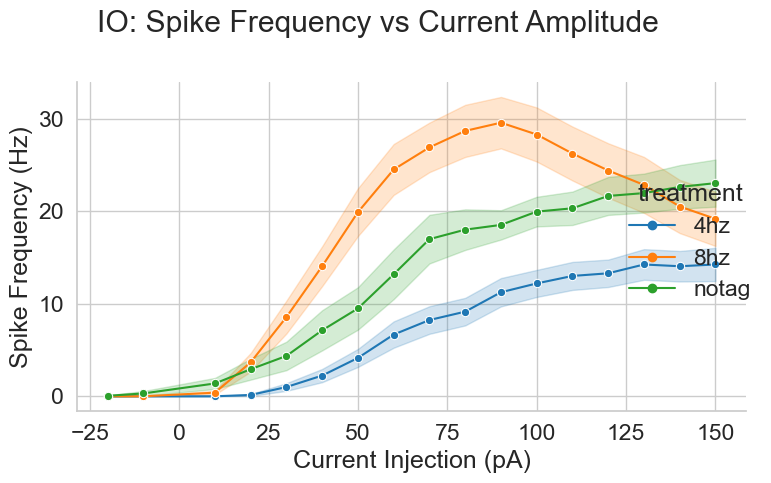

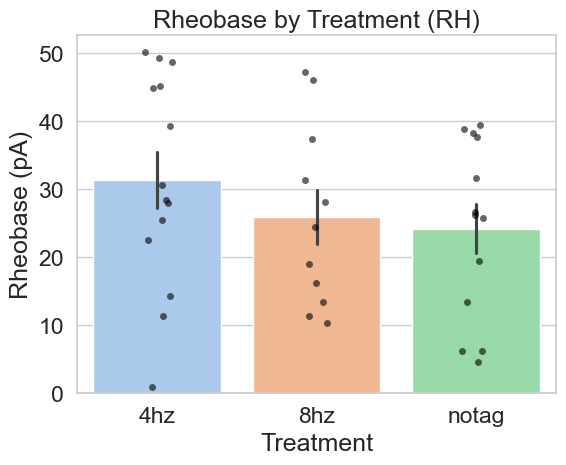

In [8]:
# ==== IO Spike Frequency vs Amp ====
df_basic_filt = pd.read_csv(os.path.join(analyzed_path, 'io_basic', 'features_filtered.csv'))
df_basic_filt = df_basic_filt[~df_basic_filt['cell_id'].isin(to_exclude)]

# build plotted data (mean ± se by treatment × amp)
io_plot_df = (
    df_basic_filt.groupby(['treatment','amp'], as_index=False)['spike_frequency']
    .agg(mean='mean', sem=lambda x: x.std(ddof=1)/np.sqrt(max(len(x),1)))
)

# draw
g = sns.relplot(
    data=df_basic_filt,
    x='amp', y='spike_frequency',
    marker='o', hue='treatment',
    kind='line', errorbar='se',
    palette='tab10',
    height=5, aspect=1.3
)
g.set_axis_labels('Current Injection (pA)', 'Spike Frequency (Hz)')
g.fig.suptitle('IO: Spike Frequency vs Current Amplitude')
plt.tight_layout()
# save figure and exact data used (use raw rows for transparency)
save_plot_and_data('io', 'io_fi_curve', df_basic_filt.copy(), g.fig, {'note':'relplot with errorbar=se'})

# ==== Rheobase (RH) ====
df_rh = pd.read_csv(os.path.join(analyzed_path, 'rh', 'features.csv'))
df_rh = df_rh.rename(columns={'file_name': 'cell_id', 'condition_0': 'treatment'})
df_rh = df_rh[~df_rh['cell_id'].isin(to_exclude)]

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(data=df_rh, x='treatment', y='rheobase', palette='pastel', errorbar='se', ax=ax)
sns.stripplot(data=df_rh, x='treatment', y='rheobase', color='black', jitter=True, alpha=0.6, ax=ax)
ax.set_title('Rheobase by Treatment (RH)')
ax.set_xlabel('Treatment')
ax.set_ylabel('Rheobase (pA)')
plt.tight_layout()
save_plot_and_data('rh', 'rheobase_by_treatment', df_rh.copy(), fig)

### 6. AP Waveform (SD) — Save figure + CSV

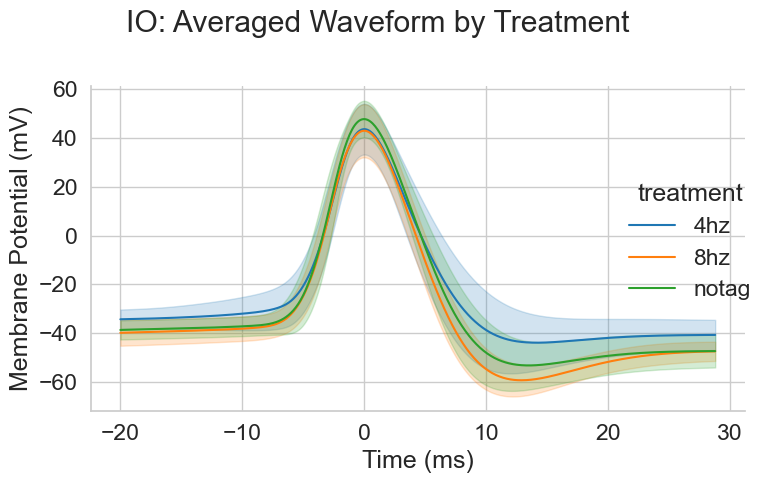

In [9]:
df_wave_filt  = pd.read_csv(os.path.join(analyzed_path, 'io_wave', 'features_filtered.csv'))
df_wave_filt = df_wave_filt[~df_wave_filt['cell_id'].isin(to_exclude)]

g = sns.relplot(
    data=df_wave_filt,
    x='time', y='mV',
    hue='treatment', kind='line',
    estimator=np.mean, errorbar='sd',
    palette='tab10',
    height=5, aspect=1.3
)
g.set_axis_labels('Time (ms)', 'Membrane Potential (mV)')
g.fig.suptitle('IO: Averaged Waveform by Treatment')
plt.tight_layout()
save_plot_and_data('io_wave', 'avg_waveform_by_treatment', df_wave_filt[['time','mV','treatment','cell_id']].copy(), g.fig)

### 7. IO & Waveform Properties — **Melted catplot** (columns → variables)

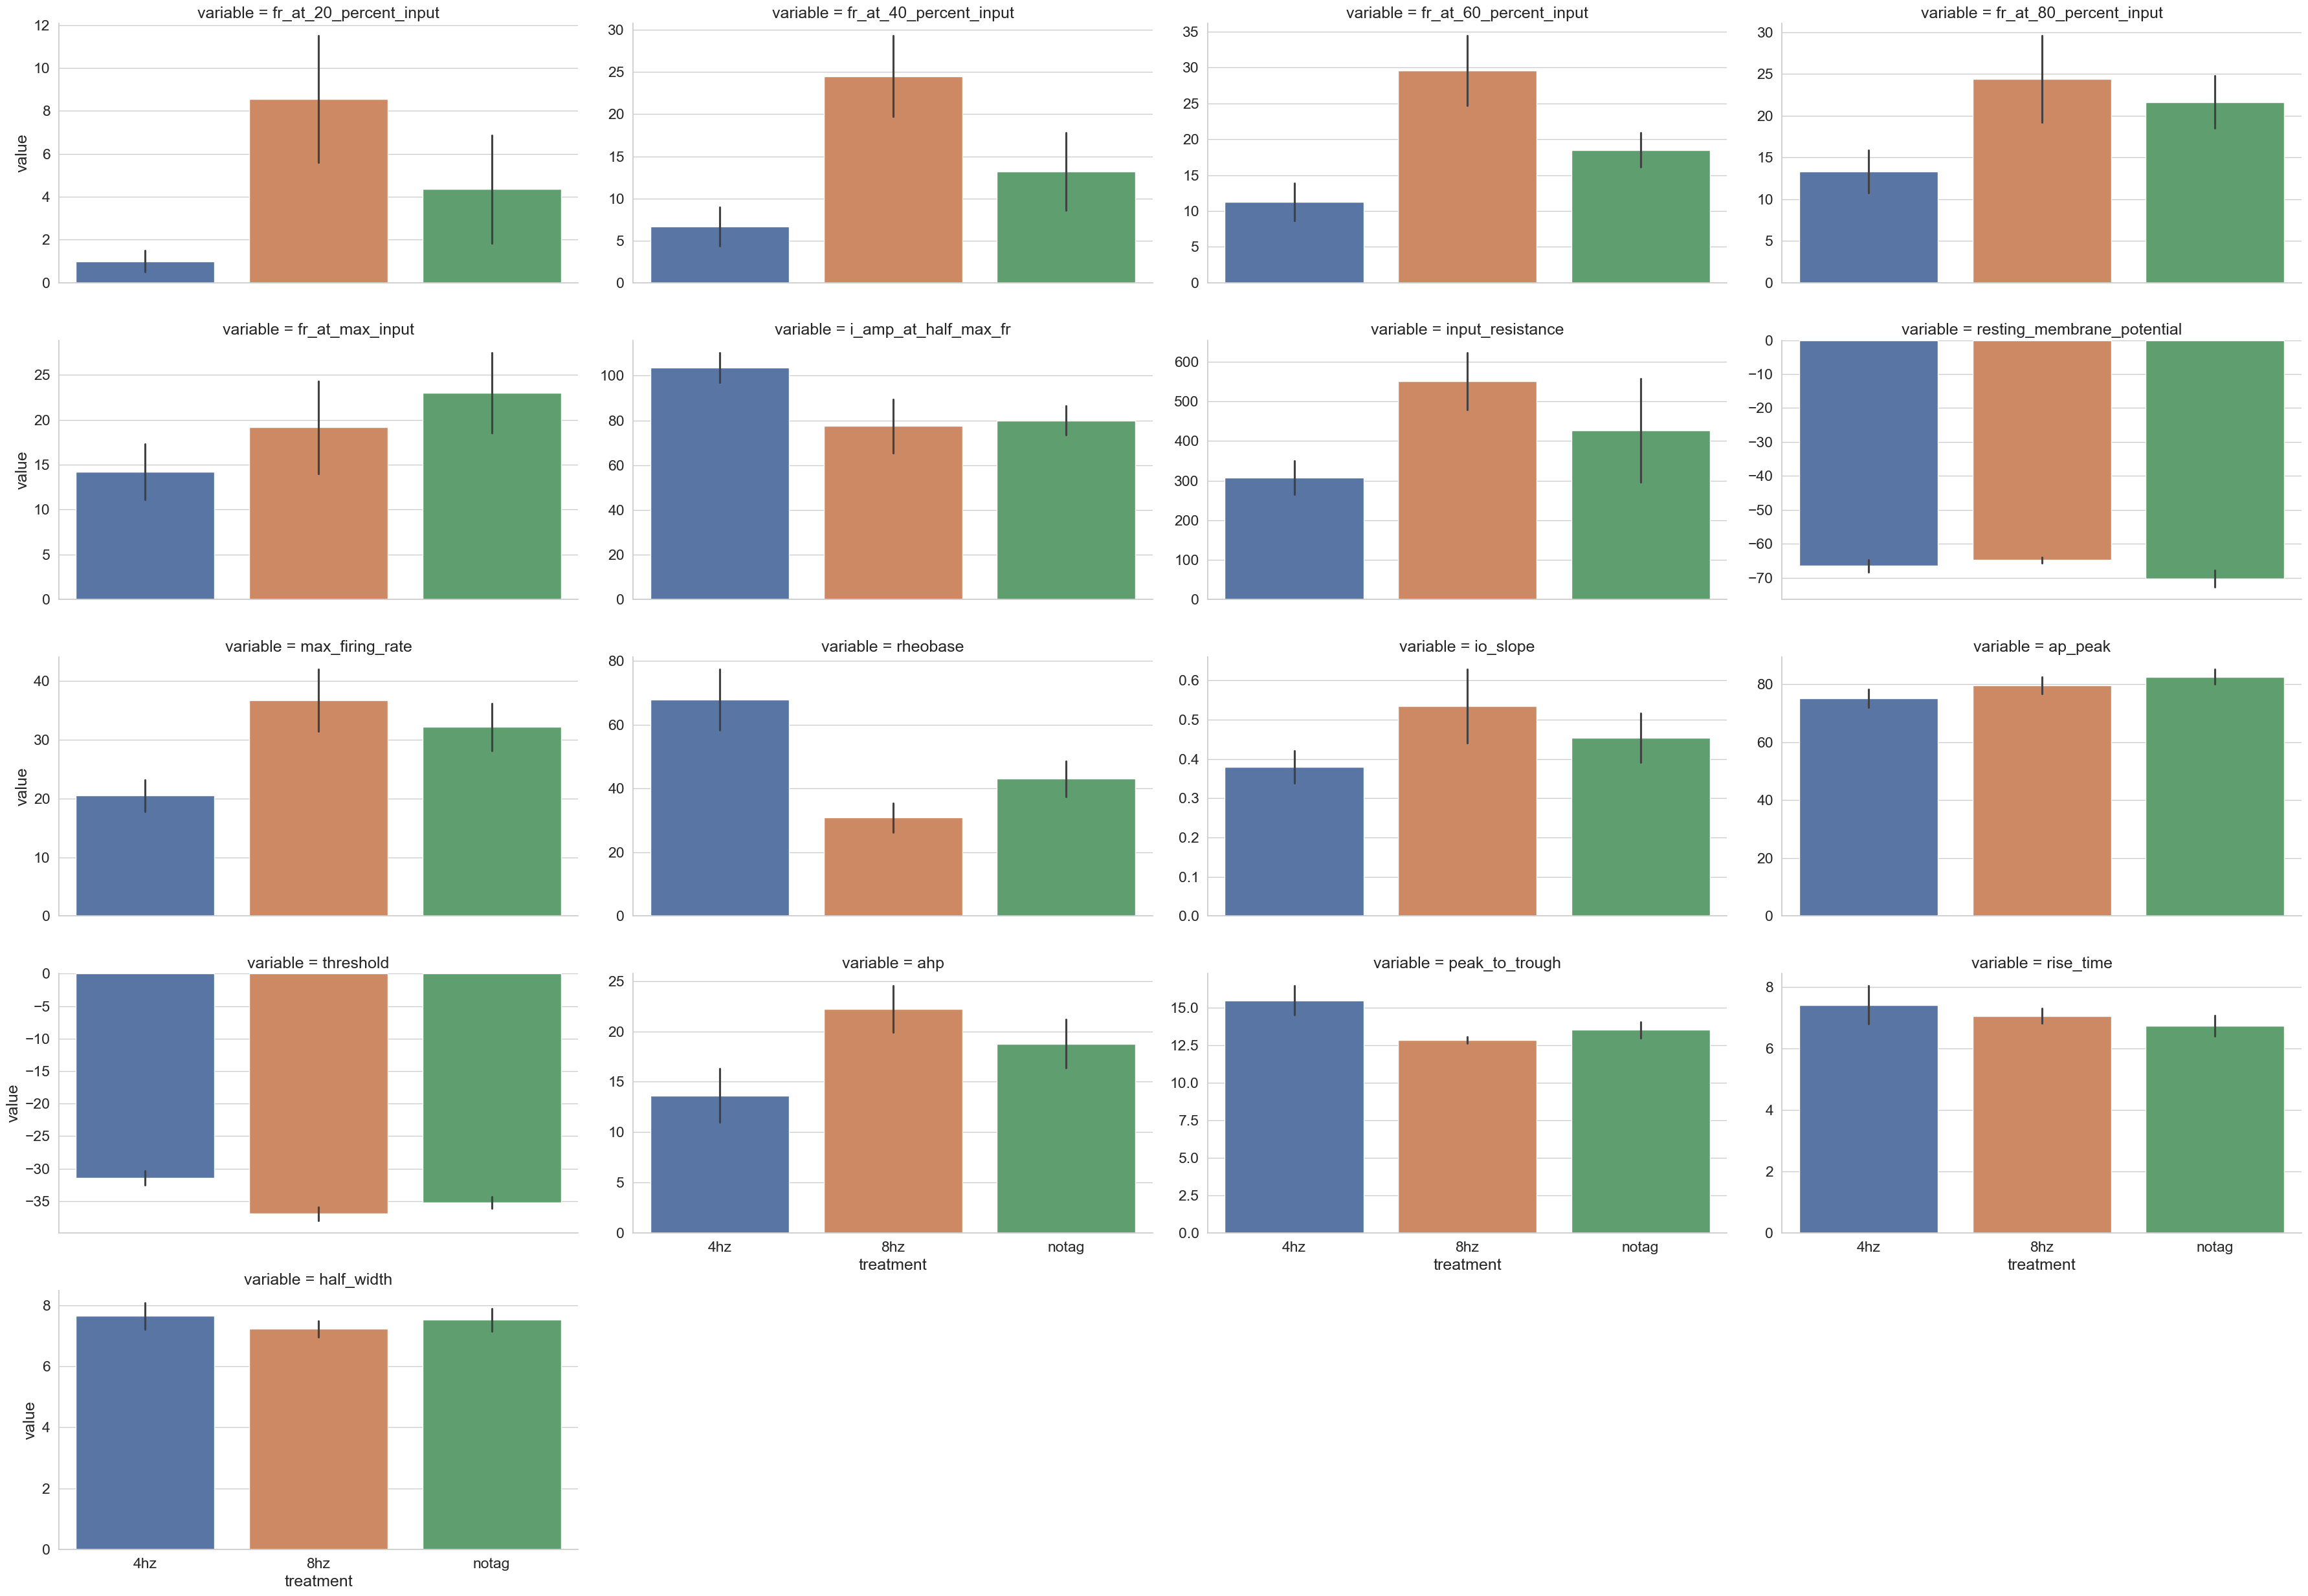

In [25]:
# Re-load summaries to avoid carryover
import warnings
warnings.filterwarnings('ignore')
df_basic_io = pd.read_csv(os.path.join(analyzed_path, 'io_basic', 'summary_io.csv'))
df_waveform = pd.read_csv(os.path.join(analyzed_path, 'io_wave', 'summary_waveform.csv'))

# Apply exclusions
df_basic_io = df_basic_io[~df_basic_io['cell_id'].isin(to_exclude)]
df_waveform = df_waveform[~df_waveform['cell_id'].isin(to_exclude)]

# Column sets (unchanged)
basic_io_cols = [
    'fr_at_20_percent_input', 'fr_at_40_percent_input', 'fr_at_60_percent_input',
    'fr_at_80_percent_input', 'fr_at_max_input', 'i_amp_at_half_max_fr',
    'input_resistance', 'resting_membrane_potential', 'max_firing_rate',
    'rheobase', 'io_slope'
]

waveform_cols = [
    'ap_peak', 'threshold', 'ahp', 'peak_to_trough', 'rise_time', 'half_width'
]

all_df = pd.merge(df_basic_io, df_waveform, on=['cell_id'], how='outer', suffixes=('_basic','_wave'))

# Melt: combine basic_io and waveform into one tidy table
basic_melt = df_basic_io.melt(id_vars=['cell_id','treatment'], value_vars=[c for c in basic_io_cols if c in df_basic_io.columns],
                              var_name='variable', value_name='value')
wave_melt  = df_waveform.melt(id_vars=['cell_id','treatment'], value_vars=[c for c in waveform_cols if c in df_waveform.columns],
                              var_name='variable', value_name='value')
all_melt   = pd.concat([basic_melt, wave_melt], ignore_index=True)

# catplot (violin + swarm overlay)
g = sns.catplot(
    data=all_melt.dropna(subset=['value']), col='variable', col_wrap=4, errorbar='se', sharey=False,
    x='treatment', y='value', hue='treatment', kind='bar',
    height=5, aspect=1.8
)
# sns.swarmplot(
#     data=all_melt.dropna(subset=['value']),
#     x='variable', y='value', hue='treatment', dodge=True, size=3, color='k', ax=g.ax
# )
# g.ax.set_title('Melted Variables (catplot)')
# g.ax.set_xlabel('Variable')
# g.ax.set_ylabel('Value (mixed units)')
# # dedupe legend
# handles, labels = g.ax.get_legend_handles_labels()
# if handles:
#     g.ax.legend(handles[:len(set(labels))], list(dict.fromkeys(labels)))

# plt.tight_layout()
save_plot_and_data('section7_melted', 'melted_catplot_all_vars', all_df, g.figure, {'note':'Variables may mix units.'})

### 8. PCA + Logistic Regression — Save PCA coordinates & figure

✅ Mean CV Accuracy: 0.514
📄 Fold Accuracies:  [0.75  0.375 0.5   0.375 0.571]


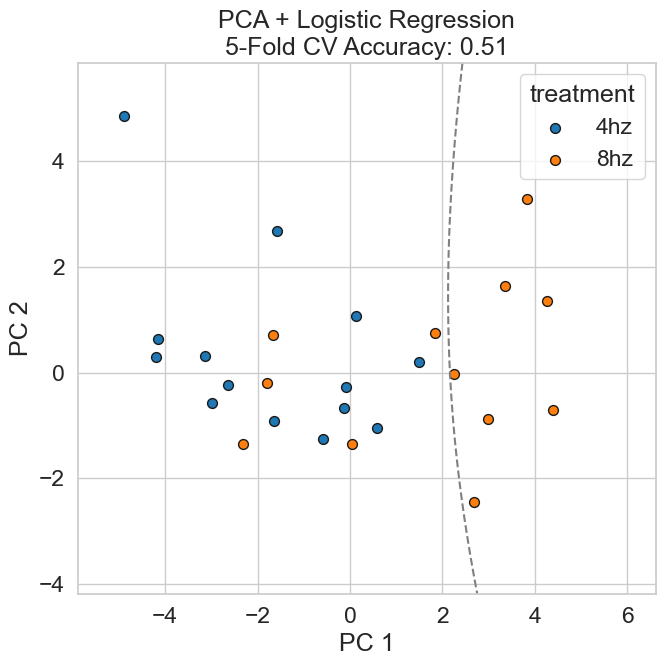

In [11]:
# Merge on cell_id & treatment
df_merged = pd.merge(
    df_basic_io, df_waveform,
    on=['cell_id','treatment'], how='inner'
)
df_merged = df_merged.fillna(df_merged.median(numeric_only=True))

features = [c for c in basic_io_cols if c in df_merged.columns] + [c for c in waveform_cols if c in df_merged.columns]
X = df_merged[features].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y = df_merged[group_col].values

pca = PCA(n_components=2, random_state=0)
X_pca = pca.fit_transform(X_scaled)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000)
scores = []

for train_idx, test_idx in skf.split(X_pca, y):
    X_train, X_test = X_pca[train_idx], X_pca[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    log_reg.fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    scores.append(accuracy_score(y_test, y_pred))

print(f"✅ Mean CV Accuracy: {np.mean(scores):.3f}")
print(f"📄 Fold Accuracies:  {np.round(scores, 3)}")

# Final model
log_reg.fit(X_pca, y)

# Decision boundary
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)
Z = log_reg.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)

fig, ax = plt.subplots(figsize=(7, 7))
for tr, col in zip(np.unique(y), ['#1f77b4', '#ff7f0e']):
    mask = y == tr
    ax.scatter(X_pca[mask, 0], X_pca[mask, 1], label=tr, c=col, edgecolor='k', s=50)
ax.contour(xx, yy, Z, levels=[0.5], linestyles='--', colors='gray')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title(f'PCA + Logistic Regression\n5-Fold CV Accuracy: {np.mean(scores):.2f}')
ax.legend(title=group_col)
plt.tight_layout()

# Save fig + PCA table
pca_df = pd.DataFrame({
    'cell_id': df_merged['cell_id'],
    'treatment': df_merged['treatment'],
    'PC1': X_pca[:,0],
    'PC2': X_pca[:,1]
})
save_plot_and_data('pca', 'pca_logreg', pca_df, fig, {'cv_scores': list(map(float, scores))})

### 9–12. Chirp & Short-Chirp — normalize, band, deltas (all plots saved + CSV)

In [12]:
stim_types_ch = ['ch', 'sch']
metrics = {'ch': 'impedance', 'sch': 'spike_count'}
file_paths = {s: os.path.join(analyzed_path, s, 'features.csv') for s in stim_types_ch}
freq_bins = (3, 6, 12, 15, 30, 60)

# Containers
dfs = {}
dfs_binned_raw = {}
dfs_binned_norm = {}
deltas_raw = {}
deltas_norm = {}

# Deltas helper
def compute_deltas(group, y):
    bp = group.set_index('freq_bins')[y]
    return pd.Series({
        'delta_3-6__6-12':   bp.get(pd.Interval(3, 6),  np.nan) - bp.get(pd.Interval(6, 12), np.nan),
        'delta_15-30__3-6':  bp.get(pd.Interval(15, 30), np.nan) - bp.get(pd.Interval(3, 6), np.nan),
        'delta_15-30__6-12': bp.get(pd.Interval(15, 30), np.nan) - bp.get(pd.Interval(6, 12), np.nan),
    })

# Process CH and SCH
for stim in stim_types_ch:
    metric = metrics[stim]

    # Load and clean
    df = pd.read_csv(file_paths[stim])
    df = df.rename(columns={'file_name': 'cell_id', 'condition_0': 'treatment'})
    try:
        df = df[~df['cell_id'].isin(to_exclude)].copy()
    except Exception:
        pass

    # Remove zero-spike cells if needed
    if metric == 'spike_count':
        total = df.groupby(['cell_id', 'treatment'])[metric].transform('sum')
        df = df[total > 0]

    # Normalize per cell×treatment
    total = df.groupby(['cell_id', 'treatment'])[metric].transform('sum')
    norm_col = f'norm_{metric}'
    df[norm_col] = df[metric] / total

    # Checks
    check = df.groupby(['cell_id', 'treatment'])[norm_col].sum().reset_index(name='sum_norm')
    print(f"--- {stim.upper()} normalization check --- min={check['sum_norm'].min():.4f} max={check['sum_norm'].max():.4f}")

    # Bin frequencies
    df['freq_bins'] = pd.cut(df['freq'], freq_bins)

    dfs[stim] = df

    # Binned RAW
    df_binned_raw = (
        df.groupby(['freq_bins', 'cell_id', 'treatment'], observed=True)[metric]
        .mean().reset_index()
    )
    dfs_binned_raw[stim] = df_binned_raw

    deltas_raw[stim] = (
        df_binned_raw.groupby(['cell_id', 'treatment'])
        .apply(compute_deltas, y=metric)
        .reset_index()
        .melt(id_vars=['cell_id', 'treatment'], var_name='delta_type', value_name=metric)
    )

    # Binned NORM
    df_binned_norm = (
        df.groupby(['freq_bins', 'cell_id', 'treatment'], observed=True)[norm_col]
        .mean().reset_index()
    )
    dfs_binned_norm[stim] = df_binned_norm

    deltas_norm[stim] = (
        df_binned_norm.groupby(['cell_id', 'treatment'])
        .apply(compute_deltas, y=norm_col)
        .reset_index()
        .melt(id_vars=['cell_id', 'treatment'], var_name='delta_type', value_name=metric)
    )

--- CH normalization check --- min=1.0000 max=1.0000
--- SCH normalization check --- min=1.0000 max=1.0000


#### 9. Raw metric vs frequency

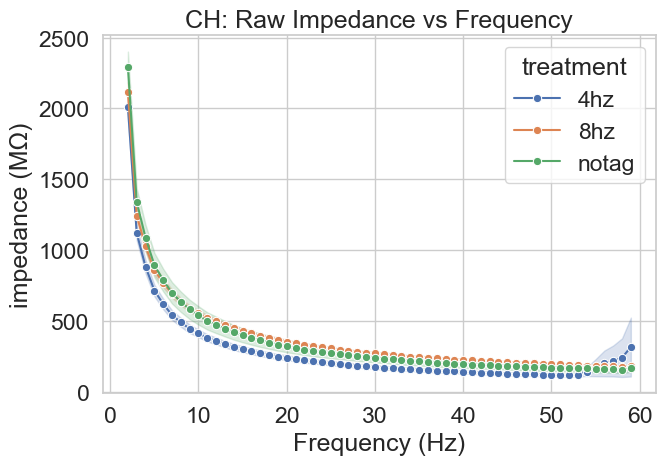

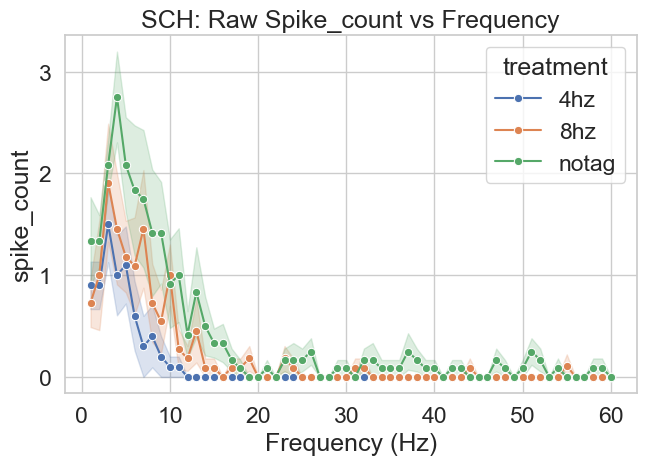

In [13]:
for stim in stim_types_ch:
    metric = metrics[stim]
    fig, ax = plt.subplots(figsize=(7,5))
    sns.lineplot(data=dfs[stim], x='freq', y=metric, hue='treatment', errorbar='se', marker='o', ax=ax)
    ax.set_title(f'{stim.upper()}: Raw {metric.capitalize()} vs Frequency')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(f'{metric} (MΩ)' if metric=='impedance' else metric)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_raw_vs_freq', dfs[stim].copy(), fig)

#### 10. Normalized metric vs frequency

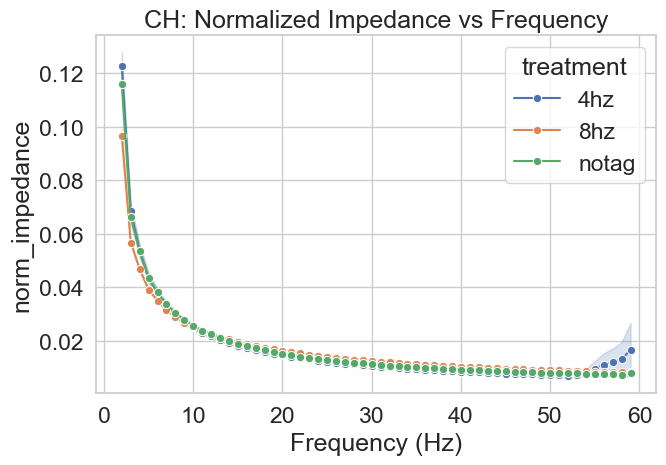

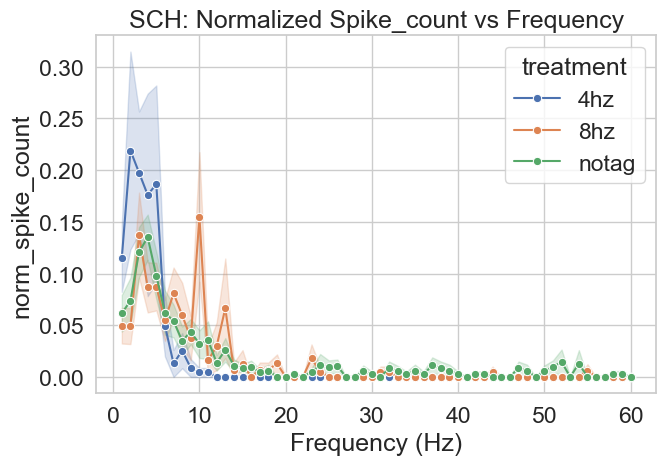

In [14]:
for stim in stim_types_ch:
    norm_col = f'norm_{metrics[stim]}'
    fig, ax = plt.subplots(figsize=(7,5))
    sns.lineplot(data=dfs[stim], x='freq', y=norm_col, hue='treatment', errorbar='se', marker='o', ax=ax)
    ax.set_title(f'{stim.UPPER() if hasattr(stim, "UPPER") else stim.upper()}: Normalized {metrics[stim].capitalize()} vs Frequency')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel(norm_col)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_normalized_vs_freq', dfs[stim].copy(), fig, {'norm_col': norm_col})

#### 11. Binned Raw & Normalized

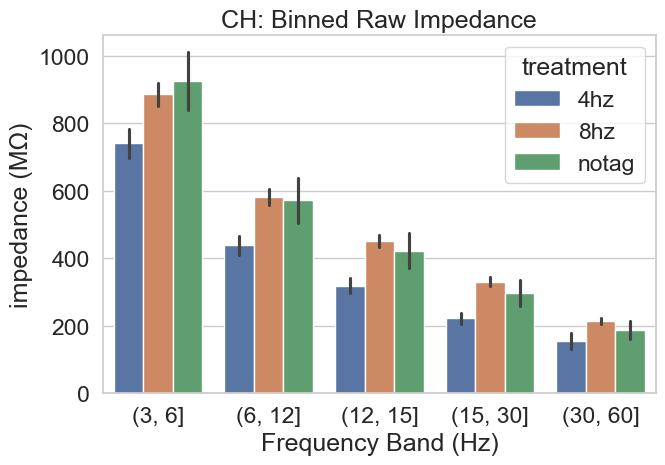

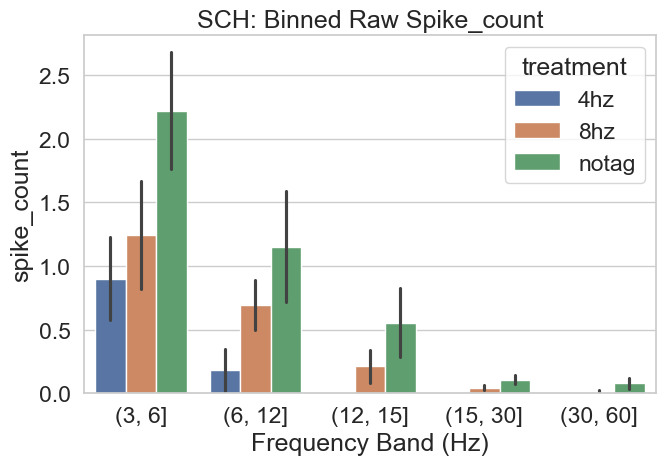

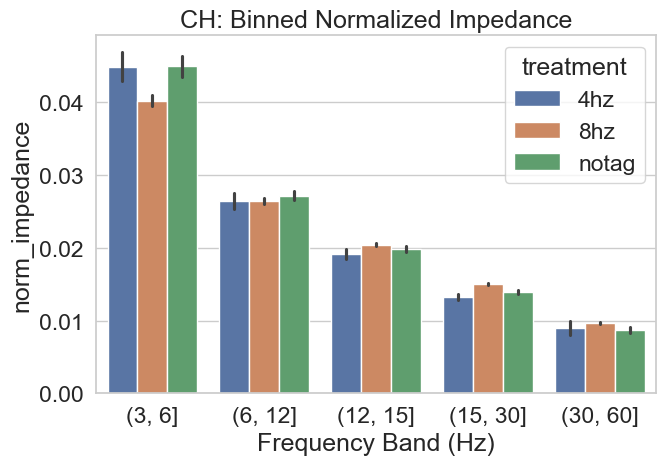

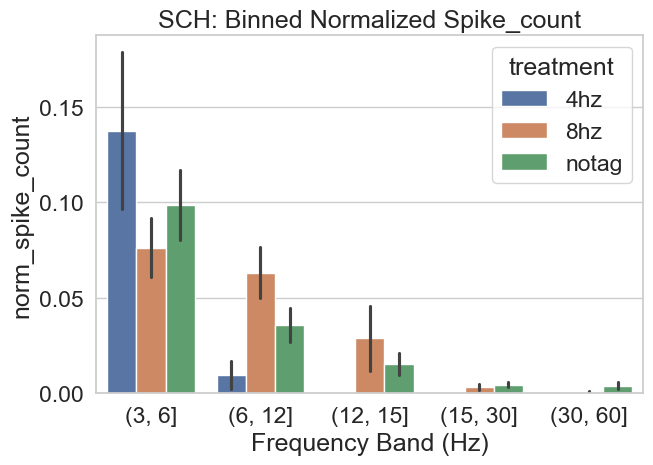

In [15]:
for stim in stim_types_ch:
    metric = metrics[stim]
    fig, ax = plt.subplots(figsize=(7,5))
    sns.barplot(data=dfs_binned_raw[stim], x='freq_bins', y=metric, hue='treatment', errorbar='se', ax=ax)
    ax.set_title(f'{stim.upper()}: Binned Raw {metric.capitalize()}')
    ax.set_xlabel('Frequency Band (Hz)')
    ax.set_ylabel(f'{metric} (MΩ)' if metric=='impedance' else metric)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_binned_raw', dfs_binned_raw[stim].copy(), fig)

for stim in stim_types_ch:
    norm_col = f'norm_{metrics[stim]}'
    fig, ax = plt.subplots(figsize=(7,5))
    sns.barplot(data=dfs_binned_norm[stim], x='freq_bins', y=norm_col, hue='treatment', errorbar='se', ax=ax)
    ax.set_title(f'{stim.upper()}: Binned Normalized {metrics[stim].capitalize()}')
    ax.set_xlabel('Frequency Band (Hz)')
    ax.set_ylabel(norm_col)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_binned_normalized', dfs_binned_norm[stim].copy(), fig, {'norm_col': norm_col})

#### 12. Deltas (raw & normalized)

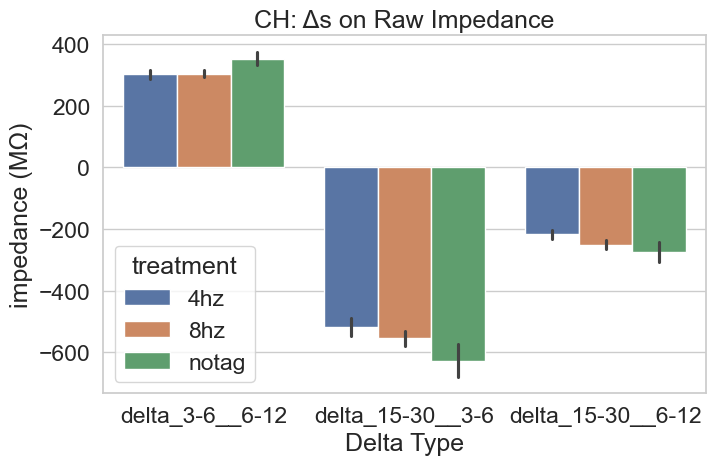

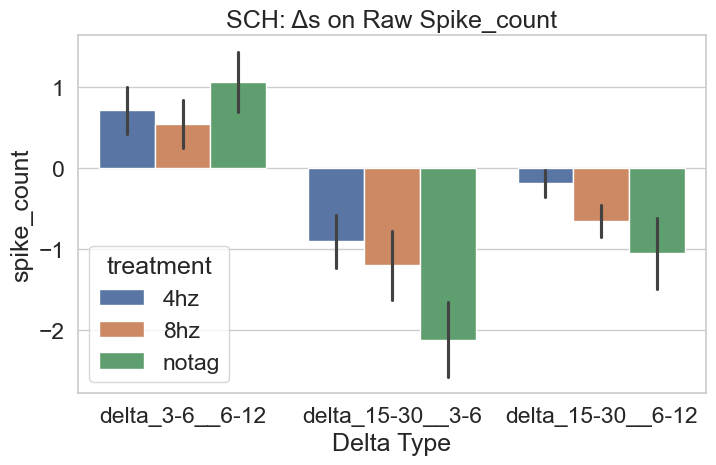

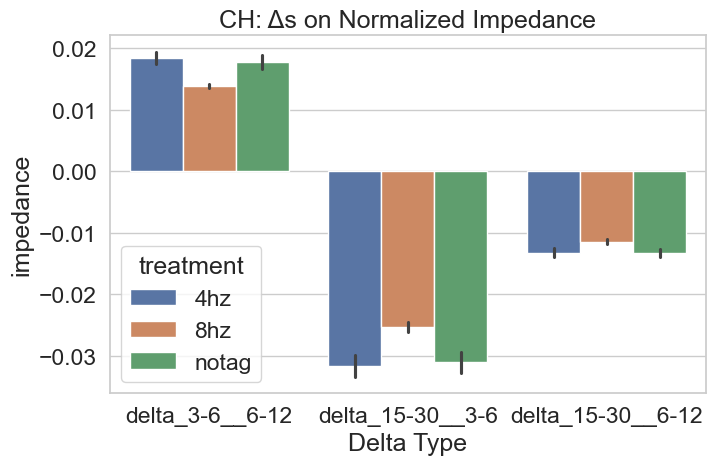

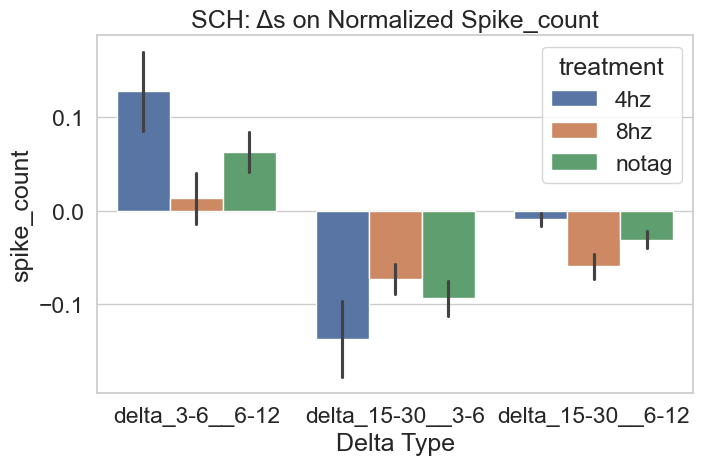

In [16]:
for stim in stim_types_ch:
    metric = metrics[stim]
    fig, ax = plt.subplots(figsize=(7.5,5))
    sns.barplot(data=deltas_raw[stim], x='delta_type', y=metric, hue='treatment', errorbar='se', ax=ax)
    ax.set_title(f'{stim.upper()}: Δs on Raw {metric.capitalize()}')
    ax.set_xlabel('Delta Type')
    ax.set_ylabel(f'{metric} (MΩ)' if metric=='impedance' else metric)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_deltas_raw', deltas_raw[stim].copy(), fig)

for stim in stim_types_ch:
    metric = metrics[stim]
    fig, ax = plt.subplots(figsize=(7.5,5))
    sns.barplot(data=deltas_norm[stim], x='delta_type', y=metric, hue='treatment', errorbar='se', ax=ax)
    ax.set_title(f'{stim.upper()}: Δs on Normalized {metric.capitalize()}')
    ax.set_xlabel('Delta Type')
    ax.set_ylabel(metric)
    plt.tight_layout()
    save_plot_and_data(f'{stim}', f'{stim}_deltas_normalized', deltas_norm[stim].copy(), fig)

## Notes
- All plots now save **PNG+SVG** + the exact **CSV** used to generate them.
- Minimal code changes; your processing logic remains intact.
- Units are preserved as in your pipeline (Vm mV, I pA, time ms, Rin MΩ, etc.).